## Install libraries

In [ ]:
pip install transformers

In [ ]:
pip install torch==1.6.0 torchvision==0.7.0

## Import Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import json
import math
import random
import pickle
import numpy as np
import pandas as pd
from tabulate import tabulate
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score,precision_score, recall_score, f1_score, matthews_corrcoef

import torch
import torch.nn as nn
from torch.optim import Adam, AdamW, SGD
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer, Trainer, TrainingArguments,AutoTokenizer
from transformers import DataCollatorWithPadding,AutoModelForSequenceClassification, AutoModel,AutoConfig
from transformers.modeling_outputs import TokenClassifierOutput


## Read Dataset

In [3]:
#df = pickle.load(open('dataset/230130_SmallOberkategorie.pickle', 'rb'))
df = pd.read_pickle("gs://transformer-textclassification/280223_beispieldaten.pickle")

label_names = df['labels'].unique()
label_names

array([0, 1, 2])

Text(0, 0.5, 'Count')

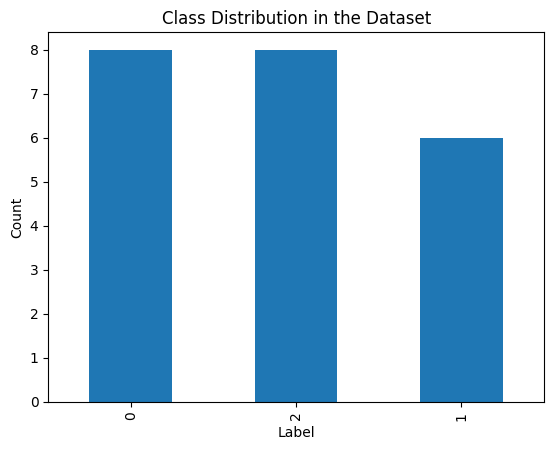

In [4]:
df['labels'].value_counts().plot(kind='bar')
plt.title("Class Distribution in the Dataset")
plt.xlabel("Label")
plt.ylabel("Count")

# Data Preprocessing
## Train Test Split

In [3]:
def split_df(X, y):    

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42, stratify=df.labels.values)

    fig, axes = plt.subplots(figsize=(12,4),nrows=1, ncols=2)

    ax1=axes[0]
    y_train.value_counts().plot(ax= ax1, kind='bar')
    ax1.set_title("Class Distribution in the Train Set")
    ax1.set_xlabel("Label")
    ax1.set_ylabel("Count")


    ax2=axes[1]
    y_val.value_counts().plot(ax=ax2, kind='bar')
    ax2.set_title("Class Distribution in the Test Set")
    ax2.set_xlabel("Label")
    ax2.set_ylabel("Count")
    plt.show()
    
    return X_train, X_val, y_train, y_val

## Tokenization

In [4]:
def tokenize(model_name):
    try:
        tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)
    except:
        tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
    return tokenizer

## Encode datasets

In [5]:
def encode(docs, tokenizer):
    '''
    This function takes list of texts and returns input_ids and attention_mask of texts
    '''
    encoded_dict = tokenizer.batch_encode_plus(docs, add_special_tokens=True, max_length=128, padding='max_length',
                            return_attention_mask=True, truncation=True, return_tensors='pt')
    input_ids = encoded_dict['input_ids']
    attention_masks = encoded_dict['attention_mask']
    return input_ids, attention_masks

## Process datasets

In [6]:
def preprocess_dataset(model_name, X, y, batch_size):
    # initialize tokenizer
    tokenizer = tokenize(model_name)
    
    # encode dataset with the tokenizer
    train_input_ids, train_att_masks = encode(X['text'].values.tolist(), tokenizer)

    
    # convert the labels into tensor
    train_y = torch.LongTensor(y.values.tolist())

    
    # convert the encoded dataset into dataloaders
    train_dataset = TensorDataset(train_input_ids, train_att_masks, train_y)
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size)
    
    return train_dataloader

# Transformer Models
## Model Creation

In [7]:
best_params_dict_path = 'best_params.text'
if os.path.exists(best_params_dict_path):
    best_prams = json.load(best_params_dict_path)
else:
    best_prams = dict.fromkeys(['best_acc', 'model', 'optimizer', 'epochs',
                            'batch_size', 'learning_rate'], 0.0)


class CustomModel(nn.Module):
    def __init__(self, checkpoint, num_labels): 
        super(CustomModel,self).__init__() 
        self.num_labels = num_labels 

        #Load Model with given checkpoint and extract its body
        self.model = model = AutoModel.from_pretrained(checkpoint,config=AutoConfig.from_pretrained(checkpoint, output_attentions=True,output_hidden_states=True))
        self.dropout = nn.Dropout(0.1) 
        self.classifier = nn.Linear(768,num_labels) # set sequence length

    def forward(self, input_ids=None, attention_mask=None,labels=None):
        #Extract outputs from the body
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask)

        #Add custom layers
        sequence_output = self.dropout(outputs[0]) #outputs[0]=last hidden state

        logits = self.classifier(sequence_output[:,0,:].view(-1,768)) # calculate losses

        loss = None
        if labels is not None:
          # set class weights here  
#           device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#           class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]).to(device) # set weights here
          loss_fct = nn.CrossEntropyLoss()
          loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        return TokenClassifierOutput(loss=loss, logits=logits, hidden_states=outputs.hidden_states,attentions=outputs.attentions)

## Model Trainer
<span style='color:red'>P1<span>

In [8]:
def trainer(model, batch_size, optimizer, epochs, train_dataloader, valid_dataloader, val_steps):

    steps = 0
    train_acc_per_epoch = []
    train_loss_per_epoch = []
    val_acc_per_epoch = []
    val_loss_per_epoch = []
    
    # Set the seed for reproducibility
    seed_val = 42
    random.seed(seed_val)
    np.random.seed(seed_val)
    torch.manual_seed(seed_val)
    torch.cuda.manual_seed_all(seed_val)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    scheduler = get_linear_schedule_with_warmup(optimizer, 
                 num_warmup_steps=0,
                num_training_steps=len(train_dataloader)*epochs )

    
    train_loss = 0
    train_total_correct = 0
    train_total_examples = 0
    
    for epoch_num in range(epochs):
        print('Epoch: ', epoch_num + 1)
        '''
        Training
        '''
        model.train()

        for step_num, batch_data in enumerate(tqdm(train_dataloader,desc='Training')):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            train_loss += loss.item()

            model.zero_grad()
            loss.backward()
            del loss

            clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
            optimizer.step()
            scheduler.step()
            
            # update accuracy
            _, predicted = torch.max(output.logits, dim=1)
            train_total_correct += (predicted == labels).sum().item()
            train_total_examples += labels.size(0)            
            steps += 1
            
            '''
            Validation
            '''

            if steps >= val_steps:
                
                model.eval()
                val_total_correct = 0
                val_total_examples = 0
                valid_loss = 0
                valid_pred = []
                valid_label = []
                with torch.no_grad():
                    for step_num_e, batch_data in enumerate(tqdm(valid_dataloader,desc='Validation')):
                        input_ids, att_mask, labels = [data.to(device) for data in batch_data]
                        output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

                        loss = output.loss
                        valid_loss += loss.item()

                        valid_label.append(labels.cpu().detach().numpy())
                        valid_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))

                        # update accuracy
                        _, predicted = torch.max(output.logits, dim=1)
                        val_total_correct += (predicted == labels).sum().item()
                        val_total_examples += labels.size(0)
                
                val_acc_per_epoch.append(val_total_correct / val_total_examples)
                val_loss_per_epoch.append(valid_loss / steps)
                
                valid_label = np.concatenate(valid_label)
                valid_pred = np.concatenate(valid_pred)
                
                print("{0}/{1} val accuracy: {2} ".format(steps, math.ceil(len(X_val) / batch_size), val_total_correct / val_total_examples))
                print("{0}/{1} val loss: {2} ".format(steps, math.ceil(len(X_val) / batch_size), valid_loss / steps))
                
                
                train_acc_per_epoch.append(train_total_correct / train_total_examples)
                train_loss_per_epoch.append(train_loss / steps)  

                print("{0}/{1} train accuracy: {2} ".format(steps, math.ceil(len(X_train) / batch_size), train_total_correct / train_total_examples))
                print("{0}/{1} train loss: {2} ".format(steps, math.ceil(len(X_train) / batch_size), train_loss / steps + 1))
                
                steps = 0
                train_loss = 0
                train_total_correct = 0
                train_total_examples = 0
    return model, train_acc_per_epoch, train_loss_per_epoch, val_acc_per_epoch, val_loss_per_epoch, valid_label, valid_pred

## Evaluation and Plotting

In [9]:
def plot_acc(epochs, train_acc_per_epoch, val_acc_per_epoch, model_name="Initial"):
    epochs_list = range(1, len(train_acc_per_epoch) +1 )
    fig, ax = plt.subplots()
    ax.plot(epochs_list,train_acc_per_epoch,label ='training accuracy')
    ax.plot(epochs_list,val_acc_per_epoch,label ='validation accuracy')
    ax.set_title('Training and Validation Accuracy of {} model'.format(model_name))
    ax.set_xlabel('Steps')
    ax.set_ylabel('Accuracy')
    ax.legend()
    '''SAVING DOES NOT WORK'''
    #img_url = 'figures/accuracy-train-' + model_name + '.png' 
    #plt.savefig(img_url)
    plt.show()
    
def plot_loss(epochs, train_loss_per_epoch, val_loss_per_epoch, model_name="Initial"):
    epochs_list = range(1, len(train_loss_per_epoch) +1 )
    fig, ax = plt.subplots()
    ax.plot(epochs_list,train_loss_per_epoch,label ='train loss')
    ax.plot(epochs_list, val_loss_per_epoch, label = 'validation loss' )
    ax.set_title('Training and Validation Loss of {} model'.format(model_name))
    ax.set_xlabel('Steps')
    ax.set_ylabel('Loss')
    ax.legend()
    '''SAVING DOES NOT WORK'''
    #img_url = 'figures/loss-train-' + model_name + '.png' '''SAVING DOES NOT WORK'''
    #plt.savefig(img_url)
    plt.show()

In [10]:
def calculate_classification_reprot(label_names, val_label, valid_pred, model_name="Initial"):
    label_names_str = [str(x) for x in label_names]
    print('classifiation report of {} model'.format(model_name))
    print(classification_report(valid_pred, val_label, target_names=label_names_str))

In [11]:
def plot_confusion_matrix(y_preds, y_true, label_names, training=False, model_name="Initial"):
    label_names_str = [str(x) for x in label_names]
    cm = confusion_matrix(y_true, y_preds, normalize=None)
    
    index= 0
    data = []
    for row in cm:
        label = label_names[index]
        total_correct = row[index]
        total_count = row.sum()
        data.append([label, total_correct, total_count])
        index += 1
    
    # Create the pandas DataFrame
    df = pd.DataFrame(data, columns = ['Label', 'Correct_preds', 'Total_preds'])
    print(df)

In [12]:
def get_evaluation_results(y_test_set, predictions):
    #store results of model
    acc = accuracy_score(y_test_set, predictions)
    precision = precision_score(y_test_set, predictions,average='macro')
    recall = recall_score(y_test_set, predictions,average='macro')
    f1 = f1_score(y_test_set, predictions,average='macro')
    mcc = matthews_corrcoef(y_test_set, predictions)
    
    results = [round(acc, 4), round(precision, 4), round(recall, 4), round(f1, 4), round(mcc, 4)]
    return results

## Training

In [13]:
def training(models, optimizers, configs, dataset):
    epochs = configs['epochs']
    batch_size = configs['batch_size']
    learning_rate = configs['learning_rate']
    val_steps = configs['val_steps']
    
    X_train, y_train, X_val, y_val = dataset.values() 
    
    # dic form store results of all models
    collect_train_results_of_all_model= {
        'Metrics':['accuracy','precision','recall','f1-score', 'MCC']
    }
    
    for model_name in models:

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        train_dataloader = preprocess_dataset(model_name, X_train, y_train, configs['batch_size'])
        valid_dataloader = preprocess_dataset(model_name, X_val, y_val, configs['batch_size'])

        '''SAVING DOES NOT WORK'''
        for optimizer_name in optimizers:
            op = str(optimizer_name).split('.')[-1].split("'")[0]
            model_name_variant = str(model_name).replace('/', '-') + '-' + op
            model_url = 'models/' + model_name_variant + '.pth' #model_url = 'models/' + model_name_variant + '.pth'
            if os.path.exists(model_url):
                continue

            print("===========================================")
            print("Start Training of {}".format(model_name_variant))
            print("===========================================")

            model = CustomModel(checkpoint=model_name, num_labels=len(label_names)).to(device)
            optimizer = optimizer_name(model.parameters(), lr=learning_rate)
            model, train_acc_per_epoch, train_loss_per_epoch, val_acc_per_epoch, val_loss_per_epoch, valid_label, valid_pred = trainer(model, batch_size, optimizer, epochs, train_dataloader, valid_dataloader, val_steps)
            
            
            val_total_correct = (valid_label == valid_pred).sum().item()
            val_acc =  val_total_correct/len(valid_label)
            print(val_acc)
            
            plot_acc(epochs, train_acc_per_epoch, val_acc_per_epoch, model_name_variant)
            plot_loss(epochs, train_loss_per_epoch, val_loss_per_epoch, model_name_variant)
#             calculate_classification_reprot(label_names, valid_label, valid_pred, model_name_variant)
            plot_confusion_matrix(valid_pred, valid_label, label_names, True, model_name_variant)
            collect_train_results_of_all_model[model_name_variant] = get_evaluation_results(valid_label, valid_pred)
            print("\n\n")
            
#             torch.save(model.state_dict(), model_url)
            if val_acc > best_prams['best_acc']:
                best_prams['model'] = str(model_name)
                best_prams['best_acc'] = val_acc
                best_prams['optimizer'] = op
                best_prams['epochs'] = epochs
                best_prams['batch_size'] = batch_size
                best_prams['learning_rate'] = learning_rate
                
                '''SAVING DOES NOT WORK'''
                with open(best_params_dict_path, "w") as fp:
                    json.dump(best_prams, fp)  # encode dict into JSON
                #torch.save(model.state_dict(), "models/best-transformer-model.pth")
                
                # fs = gcsfs.GCSFileSystem(project = 'gs://transformer-textclassification/')
                with open('models/best-transformer-model.pth', 'wb') as f:
                    torch.save(model.state_dict(), f)

                
                
            
    metrics_data_frame = pd.DataFrame.from_dict(collect_train_results_of_all_model, orient='index')
    print(tabulate(metrics_data_frame)) # convert results in to table

## Configurations and Settings
<span style='color:red'>P2<span>

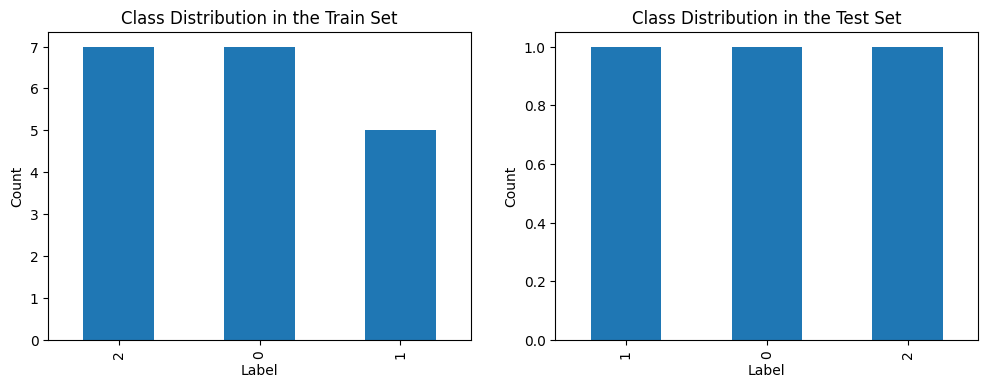

Start Training of Bert-base-german-cased-Adam


Some weights of the model checkpoint at Bert-base-german-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch:  1


Training:   0%|          | 0/2 [00:00<?, ?it/s]

UnboundLocalError: local variable 'valid_label' referenced before assignment

In [14]:
#df = pickle.load(open('dataset/230130_SmallOberkategorie.pickle', 'rb'))
df = pd.read_pickle("gs://transformer-textclassification/280223_beispieldaten.pickle") 
label_names = df['labels'].unique()
# label_names

X = df[['text']]
y = df['labels']
X_train, X_val, y_train, y_val = split_df(X, y)

optimizers = [Adam, SGD]
configs =     {'epochs': 1, 'batch_size': 16, 'learning_rate': 2e-6, 'val_steps':100}
dataset = {'X_train': X_train, 'y_train': y_train, 'X_val': X_val, 'y_val': y_val}

models = ['Bert-base-german-cased', 
#'Dbmdz/bert-base-german-uncased',
# 'Deepset/gbert-base',
# 'Xlm-roberta-base',
# 'Uklfr/gottbert-base'
]

training(models, optimizers, configs, dataset) 

# Testing

In [ ]:
def validator(model, test_dataloader):
    model.eval()
    test_label = []
    test_pred = []
    test_loss= 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    with torch.no_grad():
        for step_num, batch_data in tqdm(enumerate(test_dataloader)):
            input_ids, att_mask, labels = [data.to(device) for data in batch_data]
            output = model(input_ids = input_ids, attention_mask=att_mask, labels= labels)

            loss = output.loss
            test_loss += loss.item()
            
            test_label.append(labels.cpu().detach().numpy())
            test_pred.append(np.argmax(output.logits.cpu().detach().numpy(),axis=-1))
    
    test_label = np.concatenate(test_label)
    test_pred = np.concatenate(test_pred)
    
    return test_label, test_pred

In [ ]:
def testing(models, optimizers, configs, dataset):
    
    batch_size = configs['batch_size']
    X_test, y_test = dataset.values() 

    #dic form store results of all models
    collect_test_results_of_all_model= {
        'Metrics':['accuracy','precision','recall','f1-score', 'MCC']
    }
    
    for model_name in models:

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        test_dataloader = preprocess_dataset(model_name, X_test, y_test, configs['batch_size'])
        
        for optimizer_name in optimizers:
            op = str(optimizer_name).split('.')[-1].split("'")[0]
            model_name_variant = str(model_name).replace('/', '-') + '-' + op
            model_url = 'models/best-transformer-model.pth' #'models/best-transformer-model.pth'
            if os.path.exists(model_url):

                print("===========================================")
                print("Start Validating on {}".format(model_name_variant))
                print("===========================================")

                model = CustomModel(checkpoint=model_name, num_labels=len(label_names)).to(device)
                model.load_state_dict(torch.load(model_url))
                test_label, test_pred = validator(model, test_dataloader)

                calculate_classification_reprot(label_names, test_label, test_pred, model_name_variant)
                plot_confusion_matrix(test_pred, test_label, label_names, False, model_name_variant)

<span style='color:red'>P3<span>

In [ ]:
# df = pickle.load(open('path of the test set.pickle', 'rb'))
df = pd.read_pickle("gs://transformer-textclassification/230130_testdata.pickle")

X = df[['text']] #X_val # change with df['text'] for test text
y = df['labels'] #y_val # change with df['label'] for test labels


with open("best_params.text", "r") as fp:
    best_prams = json.load(fp)

#optimizers = [Adam, AdamW, SGD]
optimizers = [best_prams['optimizer']]

dataset = {'X_test': X, 'y_test': y}
configs =     {'epochs': 30, 'batch_size':16}
models = [best_prams['model']]



testing(models, optimizers, configs, dataset)

## check mismatches

In [ ]:
def unit_testing(model_name, optimizer, test_dataloader):
 
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
    op = str(optimizer).split('.')[-1].split("'")[0]
    model_name_variant = str(model_name).replace('/', '-') + '-' + op
#     model_url = 'models/' + model_name_variant + '.pth'
    model_url = 'models/best-transformer-model.pth' 
    
    if os.path.exists(model_url):

        model = CustomModel(checkpoint=model_name, num_labels=len(label_names)).to(device)
        model.load_state_dict(torch.load(model_url))
        test_label, test_pred = validator(model, test_dataloader)

        return test_label, test_pred
    
    return "trained model doesn't exist on path!", None


optimizer = Adam
model_name = best_prams['model']
test_dataloader = preprocess_dataset(model_name, X, y, configs['batch_size'])
test_label, test_pred = unit_testing(model_name, optimizer, test_dataloader)

mismatch_df = X
mismatch_df['label'] = test_label
mismatch_df['pred'] = test_pred
print(mismatch_df[mismatch_df['label']!=mismatch_df['pred']].shape)
mismatch_df[mismatch_df['label']!=mismatch_df['pred']][['text','label','pred']]
print(mismatch_df.head(10))
mismatch_df.to_csv('mismatched.csv')

## Attention Wights

In [ ]:
# Load pre-trained model and tokenizer
model_name = best_prams['model']
model_url = "models/best-transformer-model.pth"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = CustomModel(checkpoint=model_name, num_labels=len(label_names)).to(device)
model.load_state_dict(torch.load(model_url))

# Encode input sentence and get attention masks
input_sentence = "This is a sample input sentence to visualize attention weights."
input_tokens = tokenizer.encode(input_sentence, add_special_tokens=True)
input_tensor = torch.tensor([input_tokens]).to(device)
attention_mask = torch.ones_like(input_tensor).to(device)

# Forward pass through the model to get attention weights
outputs = model(input_tensor, attention_mask=attention_mask)
attentions = outputs[-1]

# Iterate over each layer and head to visualize attention weights
for layer, layer_attentions in enumerate(attentions):
    print(f"Layer {layer+1}:")
    for head, head_attentions in enumerate(layer_attentions):
        print(f"Head {head+1}:")
        for token, weight in zip(input_tokens, head_attentions):
            print(f"{tokenizer.decode([token])} - {weight[0][0].item():.4f}")
        print("\n")